In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from sklearn.base import clone
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, SGD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


print(tf.__version__)

2023-08-02 07:56:51.170809: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-02 07:56:51.907494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 07:56:54.118697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/eg/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as not

2.12.1


In [2]:
def get_group_data(group):
    data_list = []
    dt_list = []
    filename_list = []

    for key in group.keys():
        
        for key2 in group[key].keys():

            dt = datetime.strptime(' '.join([key.split('__')[-2], key.split('__')[-1].replace('-', ':')]), 
                                        "%Y-%m-%d %H:%M:%S:%f")
            data = np.array(group[key][key2])
            data_list.append(data)
            dt_list.append(dt)
            filename_list.append(key2)
    
    df = pd.DataFrame({'filename': filename_list, 'data': data_list, 'dt': dt_list})
    return df

def get_translations(positive, negative):
    x_translation_list = []
    y_translation_list = []
    dt_list = []

    for i in range(len(positive['data'])):
        data = positive['data'][i]
        x_translation = data[0, 3]
        y_translation = data[2, 3]
        dt = positive['dt'][i].strftime('%H:%M:%S')
        x_translation_list.append(x_translation)
        y_translation_list.append(y_translation)
        dt_list.append(dt)

    positive_df = pd.DataFrame({'x_translation': x_translation_list, 'y_translation': y_translation_list, 'dt': dt_list})

    x_translation_list = []
    y_translation_list = []
    dt_list = []

    for i in range(len(negative['data'])):
        data = negative['data'][i]
        x_translation = data[0, 3]
        y_translation = data[2, 3]
        dt = negative['dt'][i].strftime('%H:%M:%S')
        x_translation_list.append(x_translation)
        y_translation_list.append(y_translation)
        dt_list.append(dt)

    negative_df = pd.DataFrame({'x_translation': x_translation_list, 'y_translation': y_translation_list, 'dt': dt_list})

    return positive_df, negative_df

def plot_translations(positive_df, negative_df):
    positive_df['type'] = 'Positive'
    negative_df['type'] = 'Negative'

    df = pd.concat([positive_df, negative_df])

    df = df.melt(id_vars=['dt', 'type'], value_vars=['x_translation', 'y_translation'], var_name='axis', value_name='translation')

    g = sns.relplot(data=df, x='dt', y='translation', hue='axis', col='type', kind='line')

    # Reduce the number of x-axis labels
    x_ticks = g.axes[0][0].get_xticks()
    g.set(xticks=x_ticks[::10])
    g.set_xticklabels(df['dt'].unique()[::10], rotation=45)

    # Update axis titles
    g.set_axis_labels('Time', 'Translation')    
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    
    plt.show()


def plot_loss(history, num_epochs):
    plt.plot(history.history['loss'][:num_epochs], label='loss')
    plt.plot(history.history['val_loss'][:num_epochs], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [mm]')
    plt.legend()
    plt.grid(True)


def build_and_compile_model(train_features, train_labels, n_trials=100): #, epochs=500):
    def objective(trial):
        # Define the search space for the hyperparameters
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-0, log=True)
        beta_1 = trial.suggest_uniform('beta_1', 0.8, 0.99)
        beta_2 = trial.suggest_uniform('beta_2', 0.9, 0.999)
        clipvalue = trial.suggest_uniform('clipvalue', 0.1, 1.0)
        batch_size = trial.suggest_int('batch_size', 32, 256, 32)
        num_layers = trial.suggest_int('num_layers', 1, 5)
        num_neurons = trial.suggest_int('num_neurons', 16, 128, 16)
        activation = trial.suggest_categorical('activation', ['sigmoid', 'tanh', 'relu']) #'linear', 
        l1 = trial.suggest_float('l1', 1e-10, 1e-2, log=True)
        l2 = trial.suggest_float('l2', 1e-10, 1e-2, log=True)
        optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
        loss_name = trial.suggest_categorical('loss', ['mean_absolute_error', 'mean_squared_error', 'huber_loss']) #, 'log_cosh'])
        scaler_name = trial.suggest_categorical('scaler', ['normalizer', 'standard_scaler'])
        epochs = trial.suggest_int('epochs', 100, 1000)

        # Scale the data
        if scaler_name == 'normalizer':
            scaler = MinMaxScaler()
            scaled_train_features = scaler.fit_transform(train_features)
        elif scaler_name == 'standard_scaler':
            scaler = StandardScaler()
            scaled_train_features = scaler.fit_transform(train_features)

        # scaled_train_features = tf.keras.layers.Normalization(axis=-1)
        # scaled_train_features.adapt(np.array(train_features))

        # Create a neural network model
        model = keras.Sequential()
        for i in range(num_layers):
            model.add(layers.Dense(num_neurons, activation=activation, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
        # model.add(layers.Dense(16))
        model.add(layers.Dense(3))

        # Define the optimizer with the given hyperparameters
        if optimizer_name == 'adam':
            optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, clipvalue=clipvalue)
        elif optimizer_name == 'sgd':
            optimizer = SGD(learning_rate=learning_rate, clipvalue=clipvalue)
        elif optimizer_name == 'rmsprop':
            optimizer = RMSprop(learning_rate=learning_rate, clipvalue=clipvalue)

        # Compile the model
        model.compile(loss=loss_name, optimizer=optimizer, metrics=['accuracy']) #'val_accuracy', , 'loss', 'val_loss'

        # Train the model on the training data and validate on a validation split
        early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=30)
        history = model.fit(scaled_train_features, train_labels, validation_split=0.2, verbose=0, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

        # Evaluate the final performance of the model on the validation data
        val_loss = history.history['val_loss'][-1]

        return val_loss

    # Run the hyperparameter tuning
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_params

    # Scale the data with the best scaler
    if best_params['scaler'] == 'normalizer':
        scaler = MinMaxScaler()
        scaled_train_features = scaler.fit_transform(train_features)
    elif best_params['scaler'] == 'standard_scaler':
        scaler = StandardScaler()
        scaled_train_features = scaler.fit_transform(train_features)

    # Create a neural network model with the best hyperparameters
    model = keras.Sequential()
    for i in range(best_params['num_layers']):
        model.add(layers.Dense(best_params['num_neurons'], activation=best_params['activation'], kernel_regularizer=regularizers.l1_l2(l1=best_params['l1'], l2=best_params['l2'])))
    # model.add(layers.Dense(16))
    model.add(layers.Dense(3))

    # Define the optimizer with the best hyperparameters
    if best_params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'], beta_1=best_params['beta_1'], beta_2=best_params['beta_2'], clipvalue=best_params['clipvalue'])
    elif best_params['optimizer'] == 'sgd':
        optimizer = SGD(learning_rate=best_params['learning_rate'], clipvalue=best_params['clipvalue'])
    elif best_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=best_params['learning_rate'], clipvalue=best_params['clipvalue'])

    # Compile the model
    model.compile(loss=best_params['loss'], optimizer=optimizer)

    return model, best_params


In [3]:
# Get a list of all H5 files
# h5_files = glob.glob('scanner3DTop_Transformations/TESTDATASET_*/*.h5')
h5_files = glob.glob('scanner3DTop_Transformations/*/*.h5')
df_list = []

for h5_file in h5_files:

    # Open H5 file
    h5 = h5py.File(h5_file, 'r')

    # Get negative direction transformations
    negative = get_group_data(group=h5["EW/individual/transformations/negative/"])

    # Get positive direction transformations
    positive = get_group_data(group=h5["EW/individual/transformations/positive/"])

    # Combine positive and negative transformations
    transformations = pd.concat([positive, negative])

    # Extract Environment Logger data
    df = pd.read_hdf(h5_file, 'environment_logger') 

    # Merge transformations and Environment logger data
    df = df.merge(transformations, on='filename')

    # Drop unwanted columns
    df = df.drop(['directories', 'filename', 'dt'], axis=1)

    # Flatten the transformations
    df['data'] = df['data'].apply(lambda x: x.flatten())

    df['field'] = df['field'].map({'north': 0.0, 'south': 1.0})
    df['scan_direction'] = df['scan_direction'].map({'Negative': 0.0, 'Positive': 1.0})
    df = df.drop(['brightness'], axis=1) #, 'time'

    # Reset the index of your DataFrame
    df = df.reset_index(drop=True)

    # Add to list
    df_list.append(df)

df = pd.concat(df_list)
df = df.dropna()
df = df.reset_index(drop=True)

In [4]:
# Extract X, Y, Z transformations
df['data'] = df['data'].apply(lambda x: x.reshape(4, 4)[:3,3])#[:3])
# df['data'] = df['data'].astype('float')

In [5]:
df

,time,sunDirection,airPressure,relHumidity,temperature,windDirection,precipitation,windVelocity,par,field,x_position,y_position,z_position,scan_direction,data
0,2022-03-01 00:17:31,348.738670,1015.215918,28.095340,15.281228,312.603534,0.055933,2.164373,0.000000,1.0,102.1570,22.135,1.735,0.0,"[-30.0, 10.0, 0.0]"
1,2022-03-01 00:19:20,349.749443,1015.144505,28.135014,15.244606,308.439589,0.055933,2.301706,0.488341,1.0,102.8570,0.000,1.735,1.0,"[0.0, 20.0, 0.0]"
2,2022-03-01 00:21:07,350.771203,1015.065157,28.244881,15.165258,312.284921,0.055933,2.504959,0.000000,1.0,103.5565,22.135,1.735,0.0,"[-55.0, -5.0, 0.0]"
3,2022-03-01 00:22:56,351.858882,1015.120701,28.406629,15.006561,318.459426,0.055933,2.816248,0.976682,1.0,104.2570,0.000,1.735,1.0,"[20.0, 40.0, 0.0]"
4,2022-03-01 00:24:46,352.858669,1015.160375,28.247932,15.012665,324.535051,0.055933,2.444533,0.000000,1.0,104.9570,22.135,1.735,0.0,"[-30.0, 5.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,2023-07-21 16:27:18,272.403333,1004.527726,16.840114,44.298227,268.008667,0.110866,6.912442,1120.253937,0.0,304.5460,22.135,2.319,0.0,"[115.0, 85.0, 0.0]"
800,2023-07-21 16:29:13,272.721946,1004.511856,17.099521,44.578997,273.732719,0.104762,4.070559,1103.162007,0.0,305.2460,3.800,2.319,1.0,"[120.0, 30.0, 0.0]"
801,2023-07-21 16:31:07,272.919706,1004.503922,17.221595,44.548479,265.437788,0.104762,6.286203,1090.953486,0.0,305.9460,22.135,2.319,0.0,"[25.0, -15.0, 0.0]"
802,2023-07-21 16:33:00,273.216346,1004.456313,17.334513,44.426405,269.436934,0.104762,4.409314,1073.373215,0.0,306.6455,3.800,2.319,1.0,"[390.0, 250.0, 0.0]"


In [6]:
dataset = df
dataset = dataset.reset_index(drop=True)

# Convert any Timestamps in the input features to a numerical representation
dataset = dataset.apply(lambda x: x.astype(int) if np.issubdtype(x.dtype, np.datetime64) else x)

# Convert only the columns with numeric data types to float
dataset[dataset.select_dtypes(include='number').columns] = dataset.select_dtypes(include='number').astype(float)

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index, axis=0)

In [8]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('data')
test_labels = test_features.pop('data')

In [9]:
train_labels = train_labels.tolist()
train_labels = np.array(train_labels)

test_labels = test_labels.tolist()
test_labels = np.array(test_labels)

In [10]:
dnn_model, best_parameters = build_and_compile_model(train_features=train_features, train_labels=train_labels, n_trials=300)
dnn_model.build(input_shape=(None, train_features.shape[1]))
dnn_model.summary()

[I 2023-08-02 07:57:15,497] A new study created in memory with name: no-name-53a34ebe-0465-40ab-b4ba-89cd3acf3fc3
2023-08-02 07:57:17.280842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-02 07:57:18.848398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-02 07:57:18.848635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-02 07:57:18.858428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.

Model: "sequential_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1216 (Dense)          (None, 16)                240       
                                                                 
 dense_1217 (Dense)          (None, 16)                272       
                                                                 
 dense_1218 (Dense)          (None, 16)                272       
                                                                 
 dense_1219 (Dense)          (None, 16)                272       
                                                                 
 dense_1220 (Dense)          (None, 16)                272       
                                                                 
 dense_1221 (Dense)          (None, 3)                 51        
                                                                 
Total params: 1,379
Trainable params: 1,379
Non-trai

In [11]:
# Scale the data with the best scaler
if best_parameters['scaler'] == 'normalizer':
    scaler = MinMaxScaler()
    scaled_train_features = scaler.fit_transform(train_features)
elif best_parameters['scaler'] == 'standard_scaler':
    scaler = StandardScaler()
    scaled_train_features = scaler.fit_transform(train_features)

In [12]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = dnn_model.fit(
    scaled_train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, 
    epochs=best_parameters['epochs'],
    batch_size=best_parameters['batch_size'],
    use_multiprocessing=True,
    callbacks=[early_stopping])

Epoch 1/854
5/5 [==============================] - 3s 130ms/step - loss: 37.7918 - val_loss: 35.3958
Epoch 2/854
5/5 [==============================] - 0s 23ms/step - loss: 37.7288 - val_loss: 35.3652
Epoch 3/854
5/5 [==============================] - 0s 26ms/step - loss: 37.7011 - val_loss: 35.3483
Epoch 4/854
5/5 [==============================] - 0s 26ms/step - loss: 37.6840 - val_loss: 35.3300
Epoch 5/854
5/5 [==============================] - 0s 29ms/step - loss: 37.6671 - val_loss: 35.3078
Epoch 6/854
5/5 [==============================] - 0s 29ms/step - loss: 37.6468 - val_loss: 35.2764
Epoch 7/854
5/5 [==============================] - 0s 34ms/step - loss: 37.6209 - val_loss: 35.2398
Epoch 8/854
5/5 [==============================] - 0s 33ms/step - loss: 37.5910 - val_loss: 35.2003
Epoch 9/854
5/5 [==============================] - 0s 25ms/step - loss: 37.5576 - val_loss: 35.1466
Epoch 10/854
5/5 [==============================] - 0s 25ms/step - loss: 37.5147 - val_loss: 35.076

In [13]:
np.min(history.history['val_loss'])

27.00546646118164

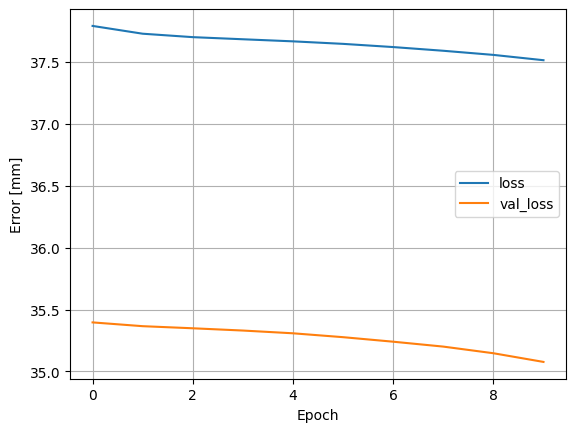

In [14]:
plot_loss(history, num_epochs=10)

In [15]:
test_labels[0][0]

15.0

In [16]:
test_predictions = dnn_model.predict(test_features)

6/6 [==============================] - 0s 3ms/step


In [17]:
test_predictions[0][1]

1.2172949e+19

In [18]:
test_labels[0]

array([15., 45.,  0.])

In [19]:
test_predictions.shape

(161, 3)

6/6 [==============================] - 0s 7ms/step


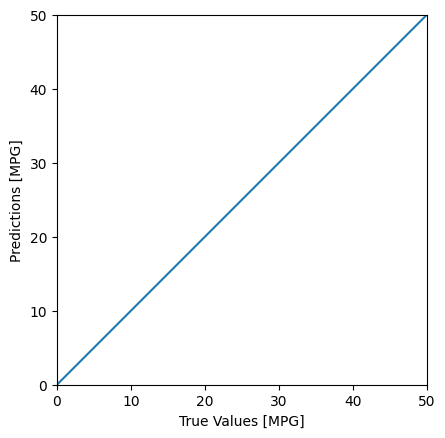

In [20]:
test_predictions = dnn_model.predict(test_features)#.flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)